<a href="https://colab.research.google.com/github/hsnbnaa/deep-learning-is-easy/blob/main/Week%204/Google%20Colab/Tugas_Week_4_PyTorch_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Preprocessing Data

In [11]:
vocab_size = 30000
maxlen = 300

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# 3. Convert ke tensor PyTorch
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.LongTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# 4. Buat dataset dan loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
embed_dim = 32
hidden_dim = 32
epochs = 10

# RNN Model

In [13]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)              # (batch_size, seq_len, embed_dim)
        out, _ = self.rnn(x)               # (batch_size, seq_len, hidden_dim)
        out = out[:, -1, :]                # ambil output timestep terakhir
        out = self.fc(out)                 # (batch_size, 1)
        return self.sigmoid(out)

In [14]:
model_rnn = RNNModel(vocab_size, embed_dim, hidden_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)

In [15]:
def train_data(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc="Training")

    for inputs, labels in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float for BCE loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().view(-1)               # <- FIXED
        correct += (preds == labels.view(-1)).sum().item()     # <- FIXED
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_loss = total_loss / total

    return train_loss, train_acc

In [16]:
def eval_data(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            total_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float().view(-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

            correct += (preds == labels.view(-1)).sum().item()
            total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total

    return val_loss, val_acc, all_labels, all_preds

In [17]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training step
    train_loss, train_acc = train_data(model_rnn, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluation step
    val_loss, val_acc, y_test, y_pred_rnn = eval_data(model_rnn, test_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print results for the current epoch
    print(f"\nEpoch {epoch+1} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



Training: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s, loss=0.563]



Epoch 1 — Train Loss: 0.6828, Train Acc: 0.5477, Val Loss: 0.6460, Val Acc: 0.6305


Training: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s, loss=0.548]



Epoch 2 — Train Loss: 0.6255, Train Acc: 0.6536, Val Loss: 0.5989, Val Acc: 0.6886


Training: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s, loss=0.45]



Epoch 3 — Train Loss: 0.5526, Train Acc: 0.7228, Val Loss: 0.5855, Val Acc: 0.6910


Training: 100%|██████████| 391/391 [00:44<00:00,  8.72it/s, loss=0.405]



Epoch 4 — Train Loss: 0.5114, Train Acc: 0.7572, Val Loss: 0.5466, Val Acc: 0.7354


Training: 100%|██████████| 391/391 [00:44<00:00,  8.74it/s, loss=0.426]



Epoch 5 — Train Loss: 0.4724, Train Acc: 0.7886, Val Loss: 0.5424, Val Acc: 0.7381


Training: 100%|██████████| 391/391 [00:44<00:00,  8.79it/s, loss=0.427]



Epoch 6 — Train Loss: 0.4180, Train Acc: 0.8220, Val Loss: 0.5135, Val Acc: 0.7604


Training: 100%|██████████| 391/391 [00:43<00:00,  8.99it/s, loss=0.452]



Epoch 7 — Train Loss: 0.3907, Train Acc: 0.8384, Val Loss: 0.4931, Val Acc: 0.7808


Training: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s, loss=0.334]



Epoch 8 — Train Loss: 0.3609, Train Acc: 0.8542, Val Loss: 0.5236, Val Acc: 0.7801


Training: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s, loss=0.646]



Epoch 9 — Train Loss: 0.3965, Train Acc: 0.8374, Val Loss: 0.6938, Val Acc: 0.5299


Training: 100%|██████████| 391/391 [00:41<00:00,  9.43it/s, loss=0.615]



Epoch 10 — Train Loss: 0.6442, Train Acc: 0.6213, Val Loss: 0.6318, Val Acc: 0.6425


In [18]:
# Evaluasi
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'

print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1-score: {f1_rnn:.4f}")

Accuracy: 0.6425
Precision: 0.6429
Recall: 0.6425
F1-score: 0.6423


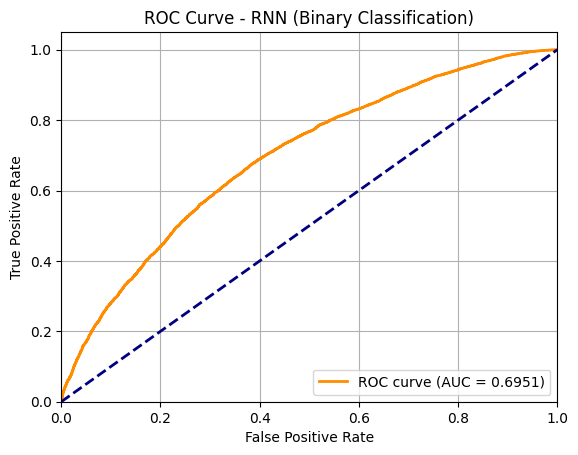

In [19]:
y_prob_rnn = []
y_true = []

model_rnn.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_rnn(inputs)
        y_prob_rnn.extend(outputs.squeeze().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_rnn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

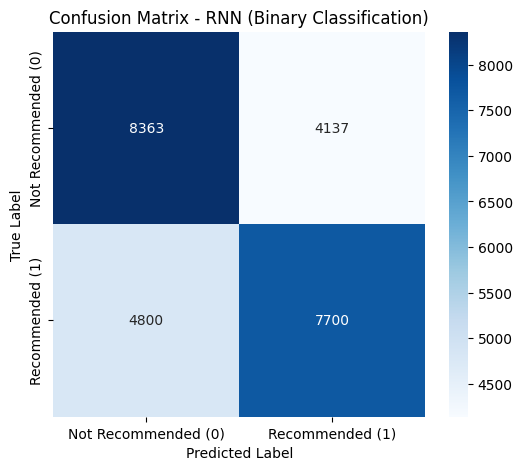

In [20]:
# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Visualisasi dengan seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recommended (0)', 'Recommended (1)'],
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RNN (Binary Classification)')
plt.show()

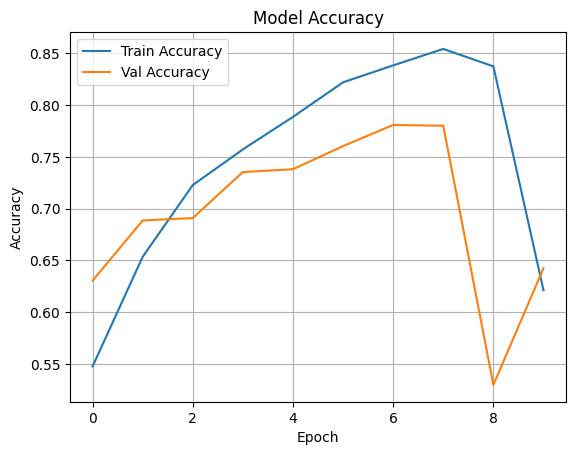

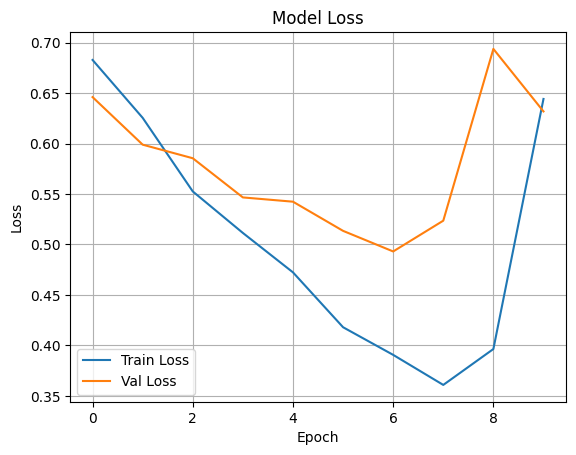

In [21]:
# Akurasi
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Model

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

In [25]:
model_lstm = LSTMModel(vocab_size, embed_dim, hidden_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

In [26]:
def train_data(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc="Training")

    for inputs, labels in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float for BCE loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().view(-1)               # <- FIXED
        correct += (preds == labels.view(-1)).sum().item()     # <- FIXED
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_loss = total_loss / total

    return train_loss, train_acc

In [27]:
def eval_data(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            total_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float().view(-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

            correct += (preds == labels.view(-1)).sum().item()
            total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total

    return val_loss, val_acc, all_labels, all_preds


In [28]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training step
    train_loss, train_acc = train_data(model_lstm, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluation step
    val_loss, val_acc, y_test, y_pred_lstm = eval_data(model_lstm, test_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print results for the current epoch
    print(f"\nEpoch {epoch+1} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



Training: 100%|██████████| 391/391 [01:41<00:00,  3.86it/s, loss=0.512]



Epoch 1 — Train Loss: 0.6381, Train Acc: 0.6207, Val Loss: 0.5958, Val Acc: 0.6863


Training: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s, loss=0.397]



Epoch 2 — Train Loss: 0.4883, Train Acc: 0.7680, Val Loss: 0.4441, Val Acc: 0.8008


Training: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s, loss=0.53]



Epoch 3 — Train Loss: 0.4061, Train Acc: 0.8178, Val Loss: 0.5402, Val Acc: 0.7215


Training: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s, loss=0.371]



Epoch 4 — Train Loss: 0.3350, Train Acc: 0.8610, Val Loss: 0.3887, Val Acc: 0.8350


Training: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s, loss=0.28]



Epoch 5 — Train Loss: 0.2899, Train Acc: 0.8856, Val Loss: 0.3998, Val Acc: 0.8363


Training: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s, loss=0.0835]



Epoch 6 — Train Loss: 0.2403, Train Acc: 0.9085, Val Loss: 0.3588, Val Acc: 0.8551


Training: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s, loss=0.438]



Epoch 7 — Train Loss: 0.2017, Train Acc: 0.9253, Val Loss: 0.4247, Val Acc: 0.8491


Training: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, loss=0.259]



Epoch 8 — Train Loss: 0.1812, Train Acc: 0.9336, Val Loss: 0.3707, Val Acc: 0.8604


Training: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s, loss=0.0596]



Epoch 9 — Train Loss: 0.1456, Train Acc: 0.9495, Val Loss: 0.3791, Val Acc: 0.8530


Training: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, loss=0.0383]



Epoch 10 — Train Loss: 0.1272, Train Acc: 0.9580, Val Loss: 0.4192, Val Acc: 0.8604


In [29]:
# Evaluasi
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

# Output
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-score: {f1_lstm:.4f}")

Accuracy: 0.8604
Precision: 0.8752
Recall: 0.8406
F1-score: 0.8576


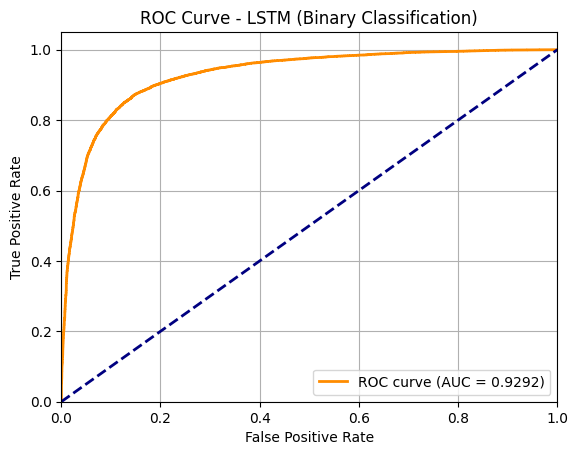

In [30]:
y_prob_lstm = []
y_true = []

model_lstm.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_lstm(inputs)
        y_prob_lstm.extend(outputs.squeeze().cpu().numpy())
        y_true.extend(labels.cpu().numpy())


# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_lstm)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

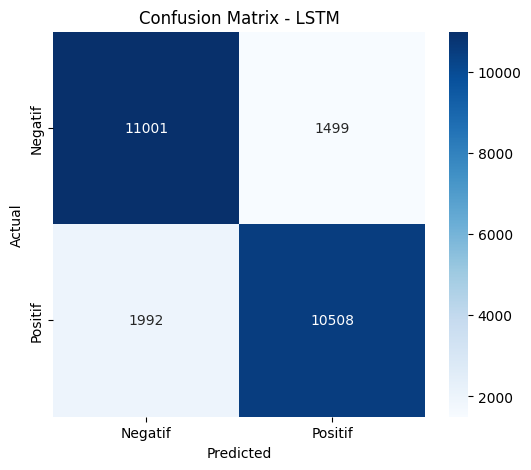

In [31]:
# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

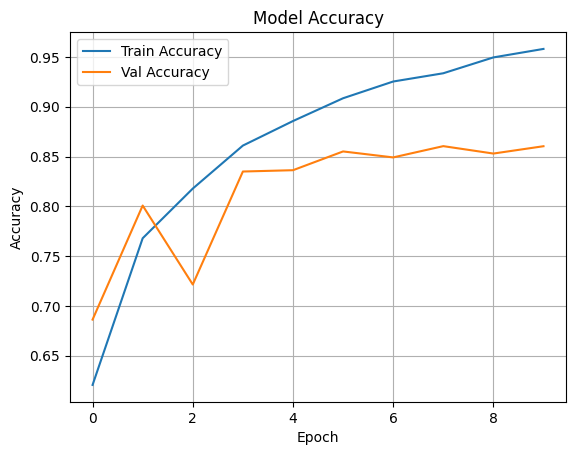

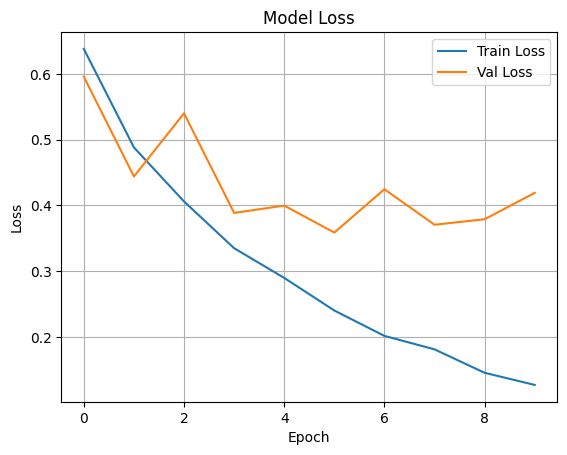

In [32]:
# Akurasi
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# GRU Model

In [33]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)


In [34]:
model_gru = GRUModel(vocab_size, embed_dim, hidden_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=1e-3)

In [35]:
def train_data(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc="Training")

    for inputs, labels in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are float for BCE loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().view(-1)               # <- FIXED
        correct += (preds == labels.view(-1)).sum().item()     # <- FIXED
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_loss = total_loss / total

    return train_loss, train_acc

In [36]:
def eval_data(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            total_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float().view(-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

            correct += (preds == labels.view(-1)).sum().item()
            total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total

    return val_loss, val_acc, all_labels, all_preds

In [37]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training step
    train_loss, train_acc = train_data(model_gru, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluation step
    val_loss, val_acc, y_test, y_pred_gru = eval_data(model_gru, test_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print results for the current epoch
    print(f"\nEpoch {epoch+1} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



Training: 100%|██████████| 391/391 [01:52<00:00,  3.48it/s, loss=0.608]



Epoch 1 — Train Loss: 0.6403, Train Acc: 0.6190, Val Loss: 0.5618, Val Acc: 0.7183


Training: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s, loss=0.507]



Epoch 2 — Train Loss: 0.4715, Train Acc: 0.7834, Val Loss: 0.4749, Val Acc: 0.7785


Training: 100%|██████████| 391/391 [00:59<00:00,  6.59it/s, loss=0.433]



Epoch 3 — Train Loss: 0.3520, Train Acc: 0.8541, Val Loss: 0.3810, Val Acc: 0.8354


Training: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s, loss=0.166]



Epoch 4 — Train Loss: 0.2820, Train Acc: 0.8890, Val Loss: 0.3536, Val Acc: 0.8508


Training: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s, loss=0.182]



Epoch 5 — Train Loss: 0.2268, Train Acc: 0.9169, Val Loss: 0.3532, Val Acc: 0.8525


Training: 100%|██████████| 391/391 [00:59<00:00,  6.62it/s, loss=0.0599]



Epoch 6 — Train Loss: 0.1882, Train Acc: 0.9328, Val Loss: 0.3867, Val Acc: 0.8584


Training: 100%|██████████| 391/391 [00:59<00:00,  6.52it/s, loss=0.247]



Epoch 7 — Train Loss: 0.1533, Train Acc: 0.9475, Val Loss: 0.3864, Val Acc: 0.8618


Training: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s, loss=0.0984]



Epoch 8 — Train Loss: 0.1278, Train Acc: 0.9579, Val Loss: 0.4028, Val Acc: 0.8624


Training: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s, loss=0.17]



Epoch 9 — Train Loss: 0.1035, Train Acc: 0.9678, Val Loss: 0.3927, Val Acc: 0.8645


Training: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s, loss=0.135]



Epoch 10 — Train Loss: 0.0789, Train Acc: 0.9772, Val Loss: 0.4154, Val Acc: 0.8636


In [38]:
# Evaluasi
accuracy_gru = accuracy_score(y_test, y_pred_gru)
precision_gru = precision_score(y_test, y_pred_gru)
recall_gru = recall_score(y_test, y_pred_gru)
f1_gru = f1_score(y_test, y_pred_gru)

# Output
print(f"Accuracy: {accuracy_gru:.4f}")
print(f"Precision: {precision_gru:.4f}")
print(f"Recall: {recall_gru:.4f}")
print(f"F1-score: {f1_gru:.4f}")

Accuracy: 0.8636
Precision: 0.8627
Recall: 0.8647
F1-score: 0.8637


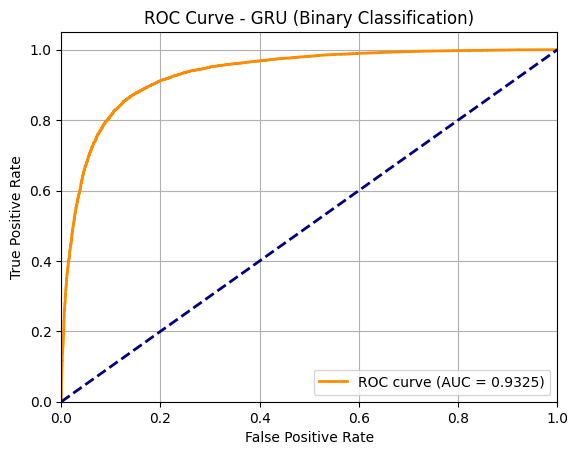

In [39]:
y_prob_gru = []
y_true = []

model_gru.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_gru(inputs)
        y_prob_gru.extend(outputs.squeeze().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_gru)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

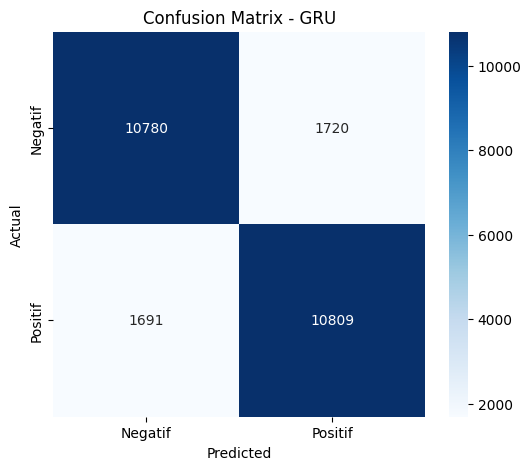

In [40]:
# Confusion Matrix
cm_gru = confusion_matrix(y_test, y_pred_gru)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - GRU')
plt.show()

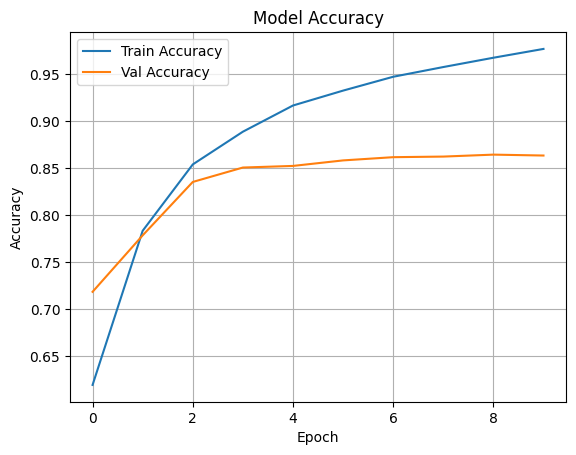

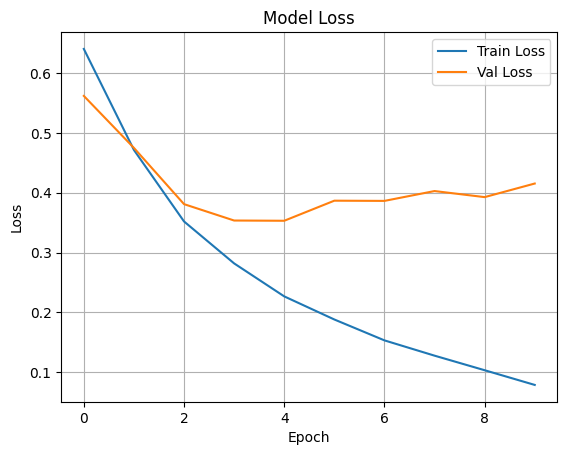

In [41]:
# Akurasi
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()